In [1]:
% matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import shared_functions_setup as setup
import scipy.interpolate
import scipy.integrate
import scipy.signal
import astropy.convolution

Script to make plots for lens distributions / source distribution

In [2]:
def get_dNdzL_nonorm(zvec, survey):
    """ Imports the lens redshift distribution from file, normalizes, interpolates, and outputs at the z vector that's passed."""

    if (survey == 'SDSS'):
        import params as pa
    elif (survey == 'LSST_DESI'):
        import params_LSST_DESI as pa
    else:
        print "We don't have support for that survey yet; exiting."
        exit()

    z, dNdz = np.loadtxt('./txtfiles/'+pa.dNdzL_file, unpack=True)
    
    # If we're dealing with SDSS, we need to 1) add the factor of 10**(-4) we've ignored in the file, 2) smooth the noisy data curve and 3) convert from n(z) (comoving number density) to dNdz
    if (survey == 'SDSS'):
        # Filter the curve 
        nofz_filt = 10**(-4) * astropy.convolution.convolve(dNdz, astropy.convolution.Box1DKernel(10))
        # Convert to dNdz
        OmL = 1. - pa.OmC - pa.OmB - pa.OmR - pa.OmN
        c_over_H = 1. / (pa.H0 * ( (pa.OmC+pa.OmB)*(1.+z)**3 + OmL + (pa.OmR+pa.OmN) * (1.+z)**4 )**(0.5))
        dNdz = nofz_filt * 4. * np.pi * pa.fsky * setup.com(z, survey, pa.cos_par_std)**2 * c_over_H # See notes October 12 2017 for this expression.
        # Also divide by area, becaus this is done to the DESI case:
        dNdz = dNdz / pa.Area_l
    
    interpolation = scipy.interpolate.interp1d(z, dNdz)
    
    if ((zvec[0]>=z[0]) and (zvec[-1]<=z[-1])):
        dNdz_return = interpolation(zvec)
    else:
        print "You have asked for dN/dzl at redshifts out of the known range."
        exit()
    
    return dNdz_return 

In [3]:
# Plot both lens distributions

z_SDSS = np.linspace(0.16, 0.36, 1000)
z_DESI = np.linspace(0.025, 1.175, 1000)

dNdzl_SDSS = setup.get_dNdzL(z_SDSS, 'SDSS')
dNdzl_DESI = setup.get_dNdzL(z_DESI, 'LSST_DESI')

# Append some zeros to the SDSS one to not make it look like it is floating.
z_app_front = np.linspace(0.12,0.16, 100)
z_app_back = np.linspace(0.36, 0.4, 100)
z_SDSS_long = np.append(np.append(z_app_front,z_SDSS), z_app_back)
dNdzl_SDSS_long = np.append(np.append(np.zeros(len(z_app_front)), dNdzl_SDSS), np.zeros(len(z_app_back)))

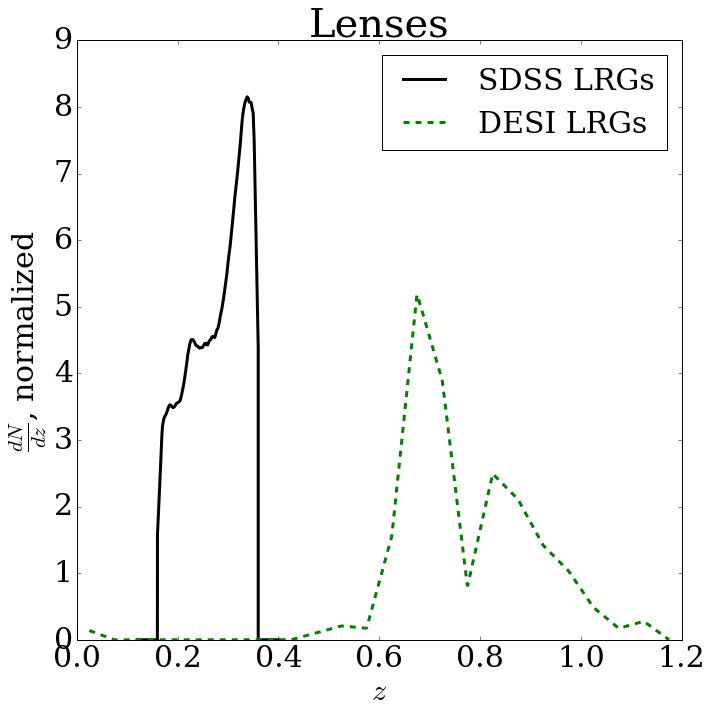

In [4]:
# SDSS LRG lenses

plt.figure(figsize=(10,10))
plt.rcParams["font.family"] = "serif"
plt.plot(z_SDSS_long, dNdzl_SDSS_long, 'k', linewidth=3, label = 'SDSS LRGs')
plt.hold(True)
plt.plot(z_DESI, dNdzl_DESI, 'g', linestyle='--',linewidth=3, label='DESI LRGs')
#plt.ylim(0, 100)
#plt.xlim(0, 0.5)
plt.xlabel('$z$', fontsize=30)
#plt.ylabel('$N / {\\rm deg}^2, \, {\\rm per\, unit\,} z$', fontsize=30)
plt.ylabel('$\\frac{dN}{dz}$, normalized', fontsize=30)
plt.tick_params(axis='both', labelsize='30')
plt.legend(fontsize=30)
plt.title('Lenses', fontsize='40')
plt.tight_layout()
#plt.show()
plt.savefig('./plots/NofZ_lens_bothsurveys.png')

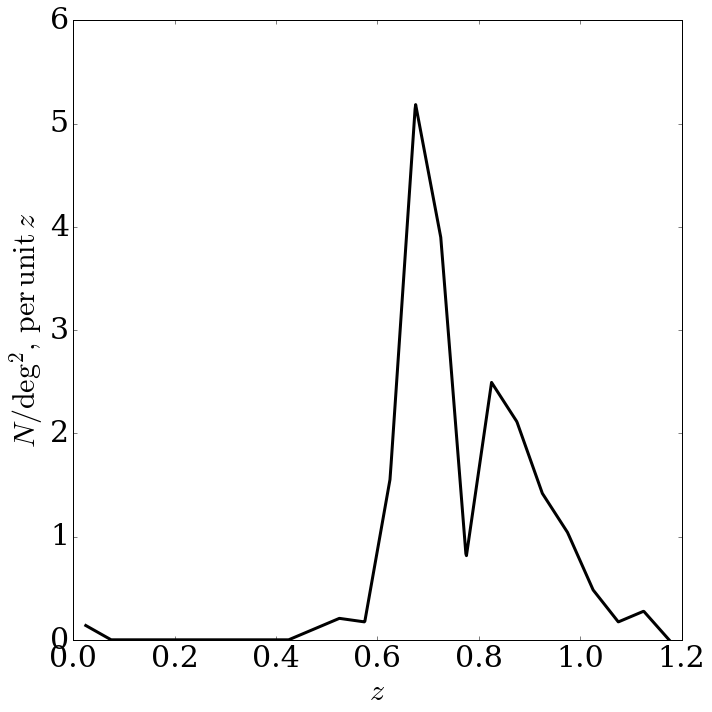

In [5]:
# DESI LRG lenses

plt.figure(figsize=(10,10))
plt.rcParams["font.family"] = "serif"
plt.plot(z_DESI, dNdzl_DESI, 'k', linewidth=3)
plt.xlabel('$z$', fontsize=30)
plt.ylabel('$N / {\\rm deg}^2, \, {\\rm per\, unit\,} z$', fontsize=30)
plt.tick_params(axis='both', labelsize='30')
plt.tight_layout()
#plt.show()
plt.savefig('./plots/NofZ_lens_DESI.png')

In [6]:
(z_SDSS_src, dNdz_unorm_SDSS) = setup.get_NofZ_unnormed([2.338, 0.303], 'Nakajima', 0., 1.5, 1000, 'SDSS')
norm = scipy.integrate.simps(dNdz_unorm_SDSS, z_SDSS_src)
dNdz_SDSS = dNdz_unorm_SDSS / norm

(z_LSST_src, dNdz_unorm_LSST) = setup.get_NofZ_unnormed([1.24, 0.51, 1.01], 'Smail', 0., 5.0, 1000, "LSST_DESI")
norm = scipy.integrate.simps(dNdz_unorm_LSST, z_LSST_src)
dNdz_LSST = dNdz_unorm_LSST / norm

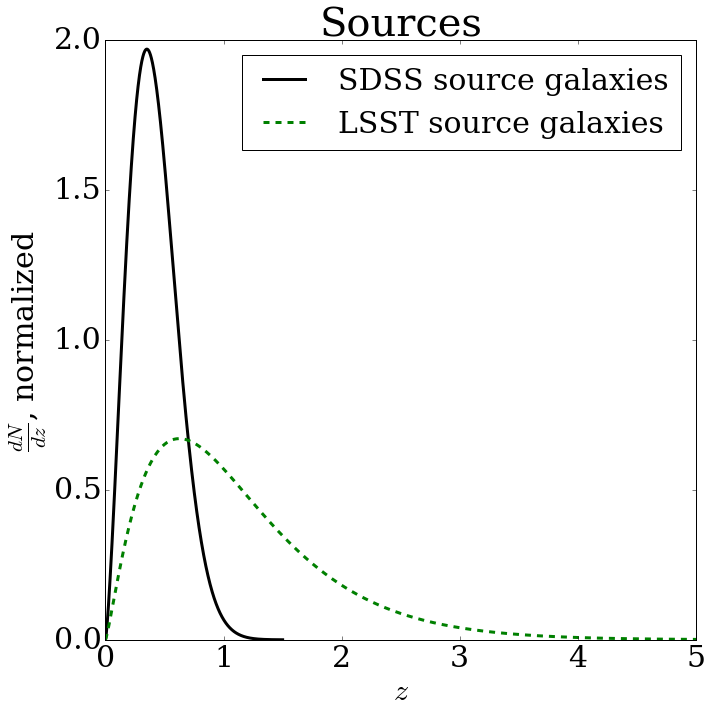

In [7]:
# SDSS shapes sources

"""Nnu	=	3.046    # Massless neutrinos
HH0 = 67.26 
OmR	=	2.47*10**(-5)/(HH0/100.)**2
OmN	=	Nnu*(7./8.)*(4./11.)**(4./3.)*OmR
OmB	=	0.02222/(HH0/100.)**2 
OmC	=	0.1199/(HH0/100.)**2 

(zcom, comz) = setup.z_interpof_com('LSST_DESI')

print zcom(comz(0.77) + 100)

print comz(zcom(comz(0.77) + 100)) * (1. + zcom(comz(0.77) + 100))"""

plt.figure(figsize=(10,10))
plt.rcParams["font.family"] = "serif"
plt.plot(z_SDSS_src, dNdz_SDSS, 'k', linewidth=3, label='SDSS source galaxies')
plt.hold(True)
plt.plot(z_LSST_src, dNdz_LSST, 'g', linestyle='--', linewidth=3, label='LSST source galaxies')
plt.xlabel('$z$', fontsize=30)
plt.ylabel('$\\frac{dN}{dz}$, normalized', fontsize=30)
plt.tick_params(axis='both', labelsize='30')
plt.legend(fontsize=30)
plt.title('Sources', fontsize='40')
plt.tight_layout()
#plt.show()
plt.savefig('./plots/NofZ_source_bothsurveys.png')


In [ ]:
# LSST shapes sources

plt.figure(figsize=(10,10))
plt.rcParams["font.family"] = "serif"
plt.plot(z_LSST_src, dNdz_LSST, 'k', linewidth=3)
plt.xlabel('$z$', fontsize=30)
plt.ylabel('$\\frac{dN}{dz}$', fontsize=35)
plt.tick_params(axis='both', labelsize='30')
plt.tight_layout()
#plt.show()
plt.savefig('./plots/NofZ_source_LSST.png')

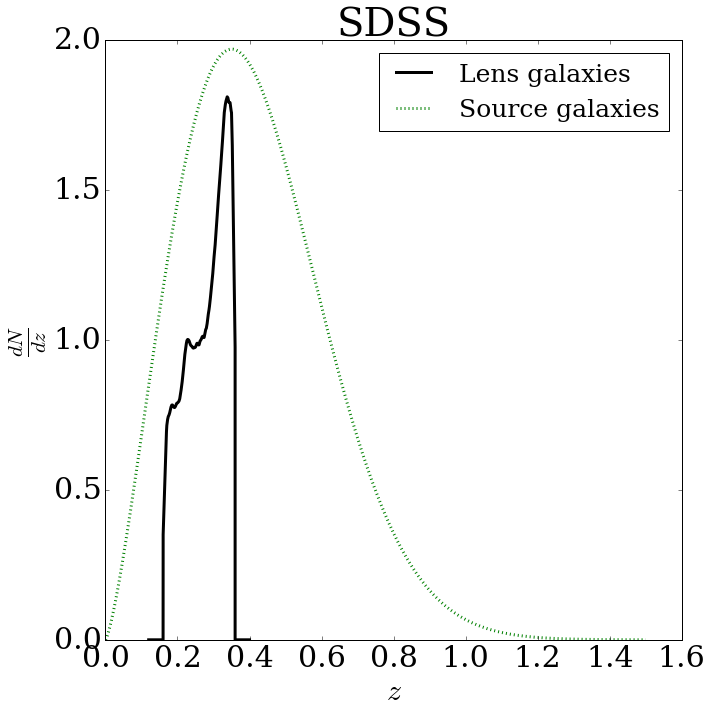

In [51]:
# Plot both SDSS sources and lenses on the same figure for intuition
plt.figure(figsize=(10,10))
plt.rcParams["font.family"] = "serif"
plt.plot(z_SDSS_long, dNdzl_SDSS_long/4.5, 'k', linewidth=3, label='Lens galaxies')
plt.hold(True)
plt.plot(z_SDSS_src, dNdz_SDSS, 'g', linewidth=3, linestyle=':', label='Source galaxies')
plt.xlabel('$z$', fontsize=30)
plt.ylabel('$\\frac{dN}{dz}$', fontsize=30)
plt.tick_params(axis='both', labelsize='30')
plt.legend(fontsize=25)
plt.title('SDSS', fontsize='40')
plt.tight_layout()
#plt.show()
plt.savefig('./plots/NofZ_lens_source_SDSS.png')

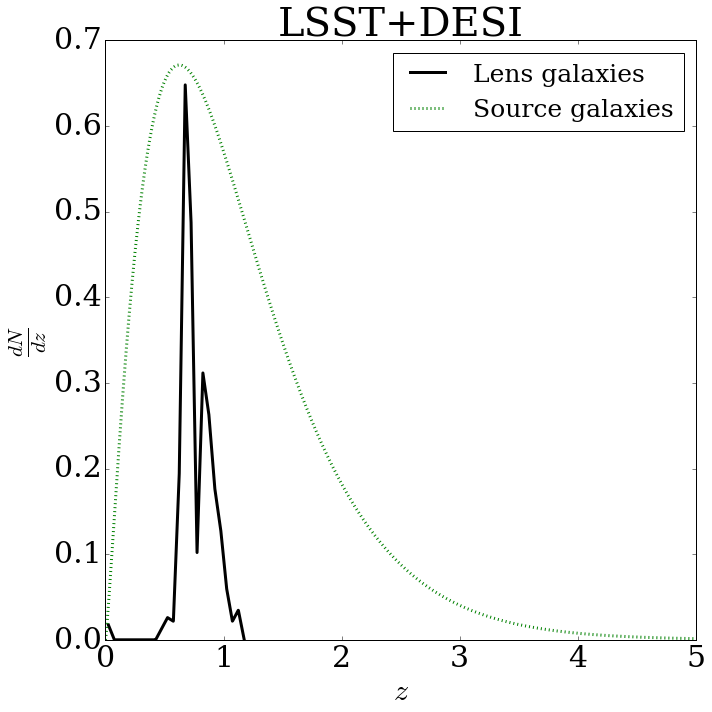

In [53]:
# Plot both SDSS sources and lenses on the same figure for intuition
plt.figure(figsize=(10,10))
plt.rcParams["font.family"] = "serif"
plt.plot(z_DESI, dNdzl_DESI/8, 'k', linewidth=3, label='Lens galaxies')
plt.hold(True)
plt.plot(z_LSST_src, dNdz_LSST, 'g', linewidth=3, linestyle=':', label='Source galaxies')
plt.xlabel('$z$', fontsize=30)
plt.ylabel('$\\frac{dN}{dz}$', fontsize=30)
plt.tick_params(axis='both', labelsize='30')
plt.legend(fontsize=25)
plt.title('LSST+DESI', fontsize='40')
plt.tight_layout()
#plt.show()
plt.savefig('./plots/NofZ_lens_source_LSST.png')

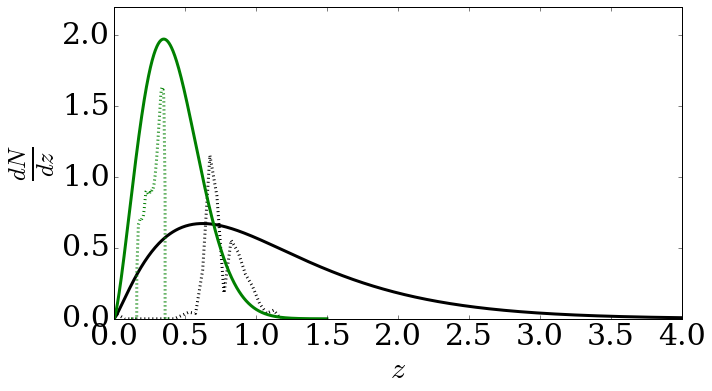

In [34]:
# Plot all four on the same plot
plt.figure(figsize=(10,10))
plt.rcParams["font.family"] = "serif"
plt.axes(aspect=1.0)
plt.plot(z_DESI, dNdzl_DESI / 4.5, 'k', linewidth=3, linestyle=':')
plt.hold(True)
plt.plot(z_LSST_src, dNdz_LSST, 'k', linewidth=3)
plt.hold(True)
plt.plot(z_SDSS_long, dNdzl_SDSS_long / 5, 'g', linewidth=3, linestyle=':')
plt.hold(True)
plt.plot(z_SDSS_src, dNdz_SDSS, 'g', linewidth=3)
plt.xlabel('$z$', fontsize=30)
plt.ylabel('$\\frac{dN}{dz}$', fontsize=35)
plt.tick_params(axis='both', labelsize='30')
plt.xlim(0.,4)
plt.ylim(0, 2.2)
plt.tight_layout()
#plt.show()
plt.savefig('./plots/NofZ_all.png')